O objetivo deste trabalho é desenvolver um pipeline completo de modelagem preditiva utilizando o dataset Canine Wellness Dataset (Synthetic). O aluno deverá comparar os algoritmos K - Nearest Neighbors (KNN) e Random Forest para identificar qual deles apresenta o melhor desempenho no problema de classificação proposto.

O trabalho envolve : exploração e pré - processamento dos dados , aplicação de técnicas de amostragem , construção e avaliação de modelos , análise estatística para comparar classificadores e definição de uma estratégia de implantação (deploy) do modelo vencedor

In [124]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [125]:
input_file = 'synthetic_dog_breed_health_data.csv' 

# --- 1. Cargar archivo ---
df = pd.read_csv(input_file,index_col= 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Breed                        9710 non-null   object 
 1   Breed Size                   9712 non-null   object 
 2   Sex                          9675 non-null   object 
 3   Age                          9709 non-null   float64
 4   Weight (lbs)                 9709 non-null   float64
 5   Spay/Neuter Status           6433 non-null   object 
 6   Daily Activity Level         7770 non-null   object 
 7   Diet                         9698 non-null   object 
 8   Food Brand                   9700 non-null   object 
 9   Daily Walk Distance (miles)  9706 non-null   float64
 10  Other Pets in Household      9702 non-null   object 
 11  Medications                  9751 non-null   object 
 12  Seizures                     9699 non-null   object 
 13  Hours of Sleep       

,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,Daily Walk Distance (miles),Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Synthetic,Healthy
ID,,,,,,,,,,,,,,,,,,,,
1,Australian Shepherd,Medium,Male,3.0,60.0,Neutered,NaN,NaN,Wellness,5.0,No,Yes,No,12.0,1.0,Active,1.0,30.0,Yes,Yes
2,Dachshund,NaN,Female,4.0,57.0,Neutered,Very Active,Home cooked,Special,2.0,Yes,No,No,11.0,3.0,NaN,0.0,47.0,Yes,NaN
3,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,1.0,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes,Yes
4,Siberian Husky,Medium,Male,13.0,35.0,NaN,Very Active,NaN,Special,4.0,No,No,No,12.0,NaN,NaN,1.0,75.0,Yes,Yes
5,Boxer,Medium,Male,13.0,35.0,NaN,Very Active,Wet food,Purina,3.0,Yes,Yes,No,9.0,1.0,NaN,0.0,64.0,Yes,No


**Pre - Procesamiento**

En esta seccion vamos a tratar los datos, comenzado por la padronizacion de los nombres de las columnas

In [126]:
# --- CONFIGURACIÓN ---
#input_file = 'synthetic_dog_breed_health_data.csv'         # tu archivo original
output_file = "teste_weka.csv"    # archivo limpio

# --- 1. Cargar archivo ---
#df = pd.read_csv(input_file,index_col= 0)

# --- 2. Limpiar nombres de columnas ---
def clean_column_name(col):
    # Reemplazar espacios por guiones bajos
    col = col.replace(" ", "_")
    # Quitar paréntesis y otros caracteres problemáticos
    col = re.sub(r"[^\w_]", "", col)
    return col

df.columns = [clean_column_name(c) for c in df.columns]

# --- 3. Limpiar valores con espacios o caracteres especiales ---
def clean_value(val):
    if isinstance(val, str):
        # Reemplazar espacios por guiones bajos en los valores
        val = val.strip().replace(" ", "_")
        # Quitar caracteres raros
        val = re.sub(r"[^\w_.-]", "", val)
    return val

df = df.applymap(clean_value)

# --- 4. Guardar archivo limpio ---
df.to_csv(output_file, index=True)

print("Archivo limpio generado:", output_file)


C:\Users\bruan\AppData\Local\Temp\ipykernel_15420\927143333.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_value)


Archivo limpio generado: teste_weka.csv


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Breed                      9710 non-null   object 
 1   Breed_Size                 9712 non-null   object 
 2   Sex                        9675 non-null   object 
 3   Age                        9709 non-null   float64
 4   Weight_lbs                 9709 non-null   float64
 5   SpayNeuter_Status          6433 non-null   object 
 6   Daily_Activity_Level       7770 non-null   object 
 7   Diet                       9698 non-null   object 
 8   Food_Brand                 9700 non-null   object 
 9   Daily_Walk_Distance_miles  9706 non-null   float64
 10  Other_Pets_in_Household    9702 non-null   object 
 11  Medications                9751 non-null   object 
 12  Seizures                   9699 non-null   object 
 13  Hours_of_Sleep             9721 non-null   float64


In [128]:
conteo = df['Healthy'].value_counts()
print("Valores nulos:", df["Healthy"].isnull().sum())
conteo

Valores nulos: 322


Healthy
Yes    7178
No     2500
Name: count, dtype: int64

Tenemos valores nulos que eliminar en la variable objetivo, estos casos de valores nulos seran eliminados luego de la imputacion para asi aprovechar la mayor cantidad de datos

In [129]:
"""
# Hacemos drop de las clase objetivo NaN para eliminar el sesgo problemas con la prediccion y evitar riesgos de ruido
df = df.dropna(subset=["Healthy"])
df = df.reset_index(drop = True)
# --- 4. Guardar archivo limpio ---
df.to_csv(output_file, index=False)
"""

'\n# Hacemos drop de las clase objetivo NaN para eliminar el sesgo problemas con la prediccion y evitar riesgos de ruido\ndf = df.dropna(subset=["Healthy"])\ndf = df.reset_index(drop = True)\n# --- 4. Guardar archivo limpio ---\ndf.to_csv(output_file, index=False)\n'

In [130]:
df = pd.read_csv("teste_weka.csv", index_col = 0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Breed                      9710 non-null   object 
 1   Breed_Size                 9712 non-null   object 
 2   Sex                        9675 non-null   object 
 3   Age                        9709 non-null   float64
 4   Weight_lbs                 9709 non-null   float64
 5   SpayNeuter_Status          6433 non-null   object 
 6   Daily_Activity_Level       7770 non-null   object 
 7   Diet                       9698 non-null   object 
 8   Food_Brand                 9700 non-null   object 
 9   Daily_Walk_Distance_miles  9706 non-null   float64
 10  Other_Pets_in_Household    9702 non-null   object 
 11  Medications                9751 non-null   object 
 12  Seizures                   9699 non-null   object 
 13  Hours_of_Sleep             9721 non-null   float64


In [131]:
df_columns = df.columns.tolist()
df_columns
#results_analysis = {}
results_nulls = {}
for i in df_columns:
    if df[i].dtype == 'float64':
        #results_analysis[i] = "numerical"
        print(i, "[numerical]")
    else:
        #results_analysis[i] = df[i].unique()
        print(i, df[i].unique())

    valor_nulo = df[i].isnull().sum()
    results_nulls[i] = valor_nulo
    print('valores nulos:', valor_nulo )

# Ordenamos el diccionario usando los valores
results_nulls = dict(sorted(results_nulls.items(), key=lambda item: item[1], reverse=True))


Breed ['Australian_Shepherd' 'Dachshund' 'Chihuahua' 'Siberian_Husky' 'Boxer'
 'Labrador_Retriever' 'Bulldog' 'Rottweiler' 'German_Shepherd'
 'Golden_Retriever' 'Poodle' 'Doberman' 'Great_Dane' 'Beagle'
 'Yorkshire_Terrier' nan]
valores nulos: 290
Breed_Size ['Medium' nan 'Small' 'Large']
valores nulos: 288
Sex ['Male' 'Female' nan]
valores nulos: 325
Age [numerical]
valores nulos: 291
Weight_lbs [numerical]
valores nulos: 291
SpayNeuter_Status ['Neutered' nan 'Spayed']
valores nulos: 3567
Daily_Activity_Level [nan 'Very_Active' 'Active' 'Moderate' 'Low']
valores nulos: 2230
Diet [nan 'Home_cooked' 'Wet_food' 'Special_diet' 'Hard_food']
valores nulos: 302
Food_Brand ['Wellness' 'Special' 'Purina' 'Iams' 'Blue_Buffalo' 'Royal_Canin' 'Nutro'
 'Pedigree' 'Hills_Science' nan]
valores nulos: 300
Daily_Walk_Distance_miles [numerical]
valores nulos: 294
Other_Pets_in_Household ['No' 'Yes' nan]
valores nulos: 298
Medications ['Yes' 'No' nan]
valores nulos: 249
Seizures ['No' 'Yes' nan]
valores

SpayNeuter_Status 3567
Daily_Activity_Level 2230
Owner_Activity_Level 2227
Average_Temperature_F 345
Sex 325
Healthy 322
Synthetic 310
Play_Time_hrs 309
Annual_Vet_Visits 306
Diet 302
Seizures 301
Food_Brand 300
Other_Pets_in_Household 298
Daily_Walk_Distance_miles 294
Age 291
Weight_lbs 291
Breed 290
Breed_Size 288
Hours_of_Sleep 279
Medications 249


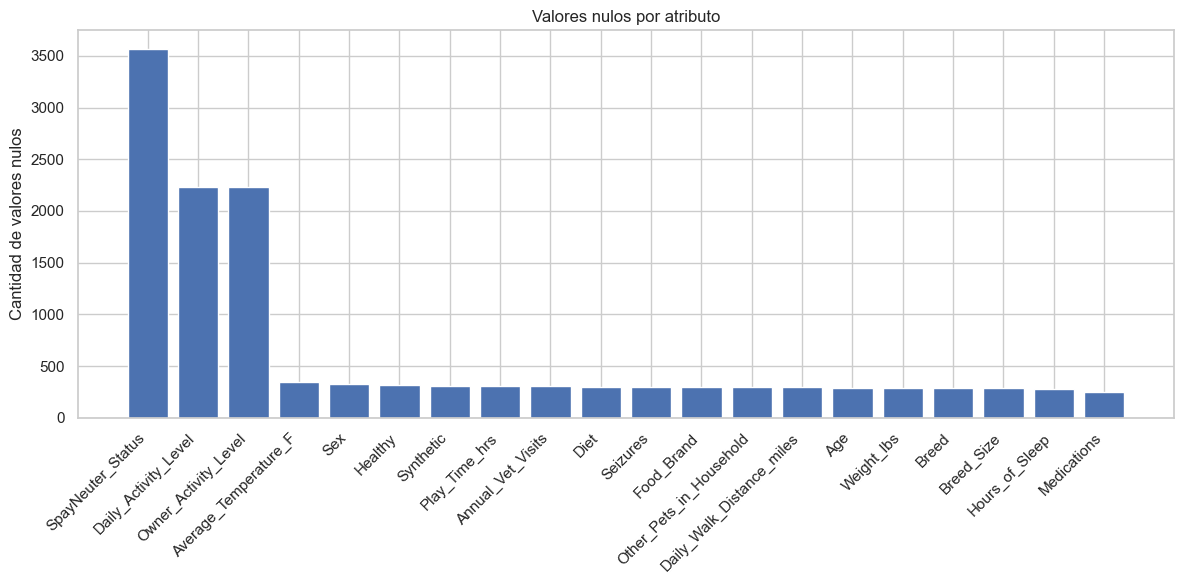

In [132]:
for clave, valor in results_nulls.items():
    print(clave,valor)

# Extraer claves y valores
columnas = list(results_nulls.keys())
nulos = list(results_nulls.values())

plt.figure(figsize=(12, 6))
plt.bar(columnas, nulos)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Cantidad de valores nulos")
plt.title("Valores nulos por atributo")

plt.tight_layout()
plt.show()

*Podemos ver que las columnas criticas a tratar por la cantidad de nulos son las columnas:*

- SpayNeuter_Status
- Daily_Activity_Level 
- Owner_Activity_Level

*Estos valores nulos son desconocidos, entonces vamos a rellenar estos valores faltantes creando una categoria Unknown.*

*Tambien vamos a rellenar los nulos del atributo Breed con Unknown para no perder la informacion contenida en esos casos.*

*Descartamos el atributo 'Synthetic' ya que este posee solo un valor.*

In [133]:
# 1. Imputación de Variables con MUCHOS nulos (>2000)
# Creamos una categoría explícita para no introducir ruido
cols_high_nulls = ['SpayNeuter_Status', 'Daily_Activity_Level', 'Owner_Activity_Level', 'Breed']
for col in cols_high_nulls:
    df[col] = df[col].fillna('Unknown')

# Hacemos drop de la columan Synthetic

df.drop('Synthetic', axis=1, inplace=True)

*Hipotesis: El atributo Weight esta correlacionado con el atributo Breed_Size*

Vamos a verificar esto y en caso de que la hipotesis sea correcta vamos a rellenar los valores nulos de Breed_size con lo valores de Weight.

Para ello deberiamos de observar que a mayor tamaño de la raza se tiene un valor medio mayor en el peso.

C:\Users\bruan\AppData\Local\Temp\ipykernel_15420\2750278184.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


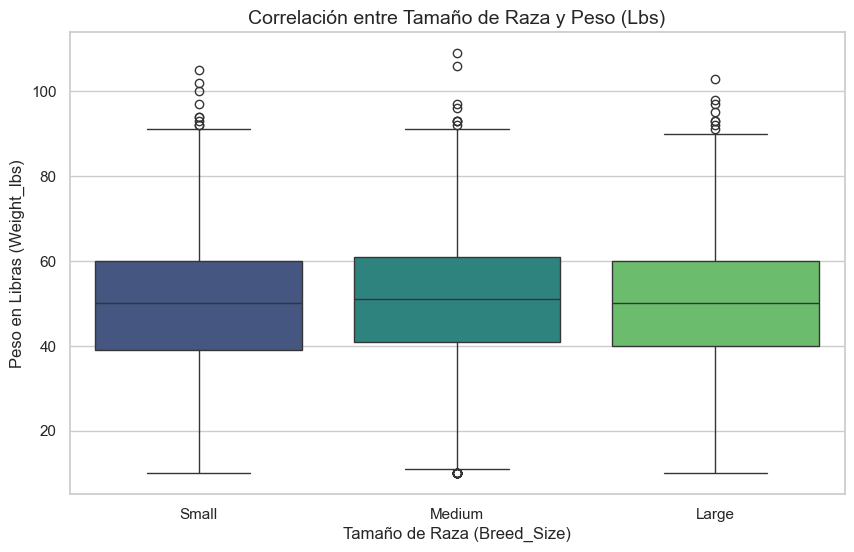

In [134]:
import seaborn as sns

# 1. Configurar el estilo del gráfico
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# 2. Definir el orden lógico de las categorías para que el gráfico sea legible
order_sizes = ['Small', 'Medium', 'Large']

# 3. Crear el Box Plot
# Esto muestra la mediana, cuartiles y outliers del peso para cada tamaño
sns.boxplot(
    data=df, 
    x='Breed_Size', 
    y='Weight_lbs', 
    order=order_sizes,
    palette="viridis"
)

# 4. Añadir títulos y etiquetas
plt.title('Correlación entre Tamaño de Raza y Peso (Lbs)', fontsize=14)
plt.xlabel('Tamaño de Raza (Breed_Size)', fontsize=12)
plt.ylabel('Peso en Libras (Weight_lbs)', fontsize=12)

# 5. Mostrar el gráfico
plt.show()

*Hipotesis Falsa!*

No se tiene una correlacion entre os valores entre el peso y el tamaño de la raza.

Ahora, como el atributo Breed_Size no refleja una caracteristica real, este atributo no aporta un valor predictivo en el modelo, entonces vamos a descartar el atributo del dataset.

In [135]:
df.drop(['Breed_Size'], axis=1, inplace=True)

*Ahora vamos a graficar los valores numericos para visualizar su distribucion*

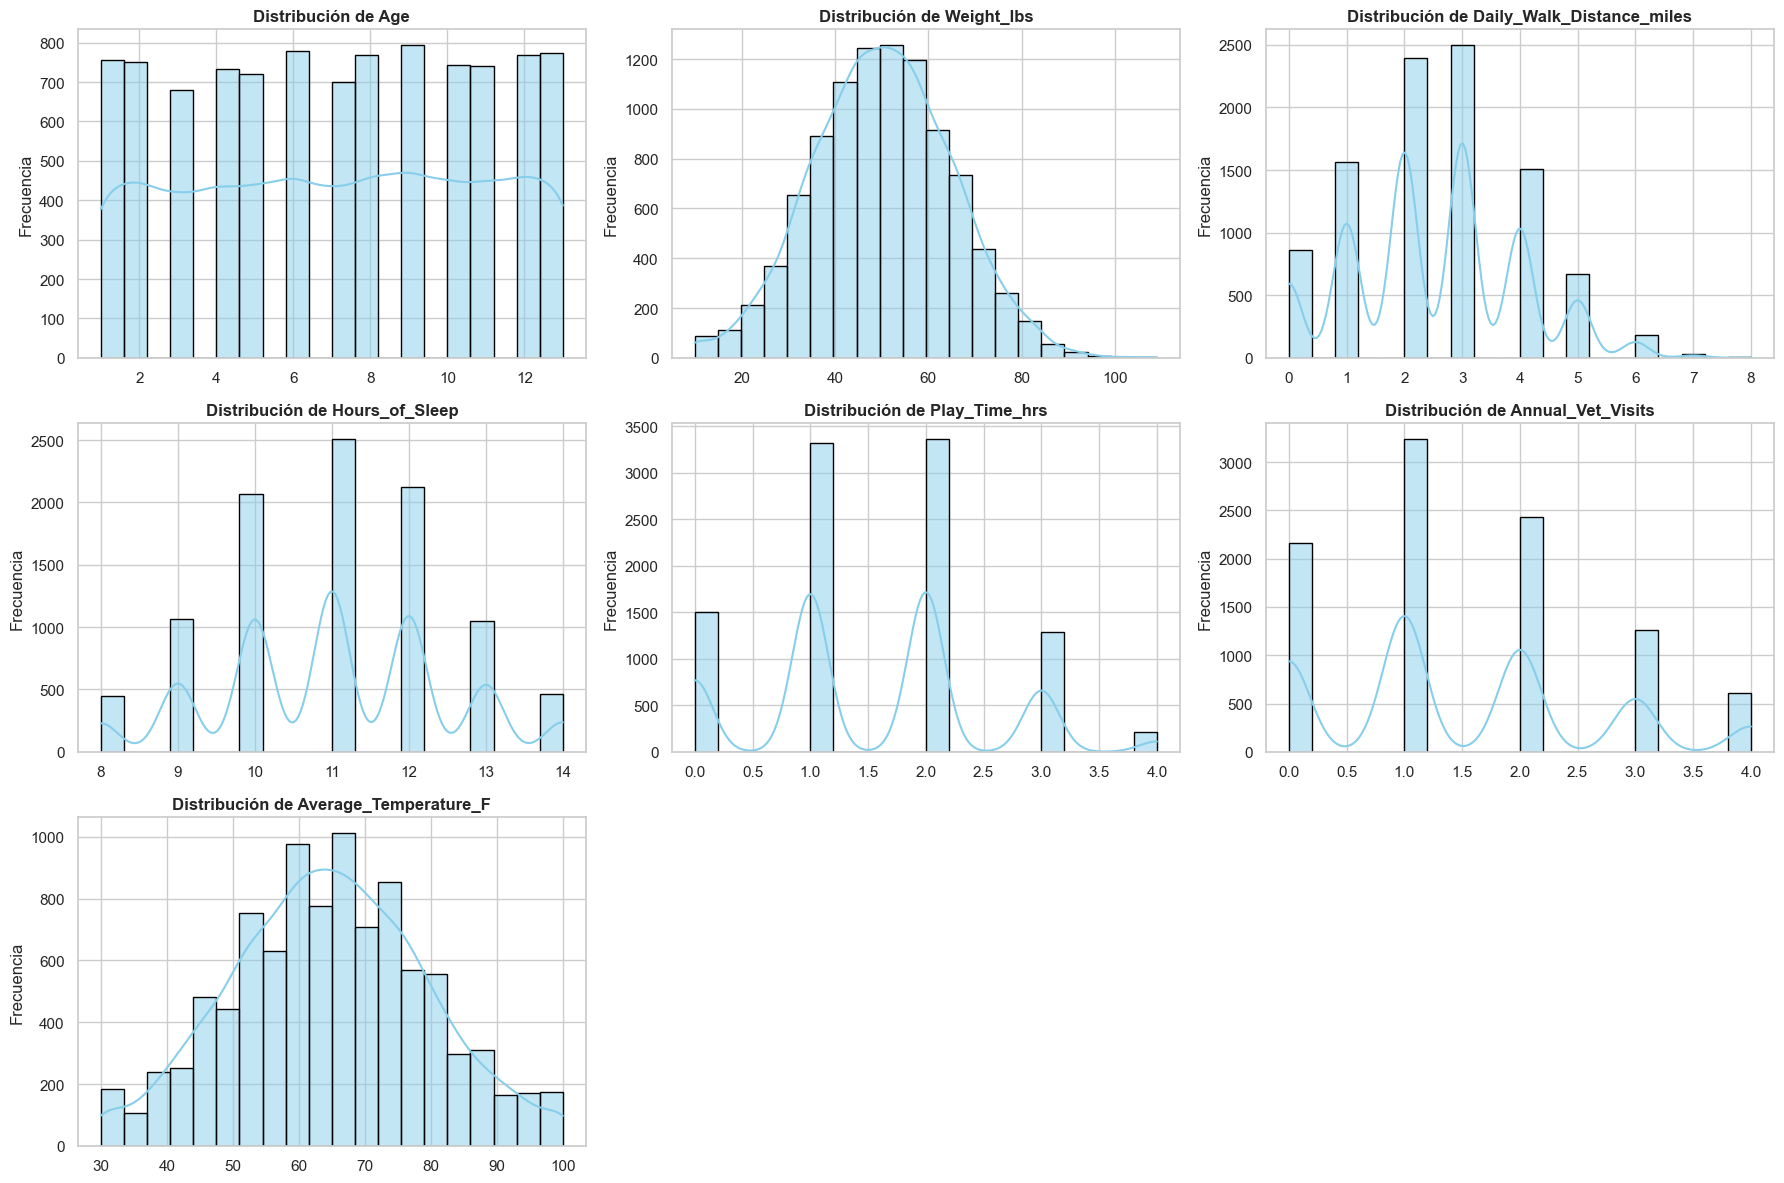

In [136]:
import math

# Lista de columnas numéricas
num_cols = ['Age', 'Weight_lbs', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
            'Play_Time_hrs', 'Annual_Vet_Visits', 'Average_Temperature_F']

# Configuración del grid (filas y columnas dinámicas)
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(18, 4 * n_rows))
sns.set_theme(style="whitegrid")

for i, col in enumerate(num_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Opción A: Histograma con curva de densidad (KDE)
    sns.histplot(data=df, x=col, kde=True, color="skyblue", edgecolor="black", bins=20)
    
    plt.title(f'Distribución de {col}', fontsize=12, fontweight='bold')
    plt.xlabel('') # Limpiamos etiqueta x para no saturar
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [137]:
num_cols_disc = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
            'Play_Time_hrs', 'Annual_Vet_Visits']

for i in num_cols_disc:
    print(i, df[i].unique())

Age [ 3.  4. 12. 13.  2.  8. 11. nan  5. 10.  7.  9.  6.  1.]
Daily_Walk_Distance_miles [ 5.  2.  1.  4.  3.  0. nan  6.  7.  8.]
Hours_of_Sleep [12. 11. 10.  9.  8. 13. 14. nan]
Play_Time_hrs [ 1.  3. nan  2.  0.  4.]
Annual_Vet_Visits [ 1.  0.  2.  4. nan  3.]


Podemos observar en los graficos que:

- Tenemos distribuciones normales en los atributos Weight_lbs y Average_Temperature_F. De esta forma, para tratar los valores nulos seria una mejor practica usar imputacion por la Media, ya que seria un mejor estimador.
- Para los atributos; Daily_Walk_Distance_miles, Hours_of_Sleep, Play_Time_hrs, Annual_Vet_Visits, Age. Se observa una distribucion no normal, plana para el caso del atributo Age y variables discretas con picos definidos para los demas atributos, debido a esto la imputacion por la media seria la mejor opcion.

**Pre-Procesamiento: Split y Imputacion**

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# 0. Configuración para que Scikit-Learn devuelva Pandas DataFrames (y no arrays numpy)
from sklearn import set_config
set_config(transform_output="pandas")

# --- PASO 1: Definir Listas de Columnas ---
# Normales (Gaussiana) -> Usaremos MEDIA
cols_normales = ['Weight_lbs', 'Average_Temperature_F']

# Sesgadas/Discretas -> Usaremos MEDIANA
cols_sesgadas = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
                 'Play_Time_hrs', 'Annual_Vet_Visits']

# Categóricas -> Usaremos MODA
# (Asegúrate de incluir todas tus categóricas aquí)
cols_categoricas = [
    'Sex', 'SpayNeuter_Status', 'Daily_Activity_Level', 
    'Diet', 'Food_Brand', 'Other_Pets_in_Household', 'Medications', 
    'Seizures', 'Owner_Activity_Level'
]

# --- PASO 2: División de Datos (Split) ---
# Eliminamos filas donde la variable objetivo 'Healthy' sea nula
df_clean = df.dropna(subset=['Healthy']).copy()

X = df_clean.drop('Healthy', axis=1)
y = df_clean['Healthy']

# División: 80% Train, 10% Val, 10% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- PASO 3: Configurar el Imputador (Solo Rellenar) ---
imputador_maestro = ColumnTransformer(
    transformers=[
        ('normales', SimpleImputer(strategy='mean'), cols_normales),
        ('sesgadas', SimpleImputer(strategy='median'), cols_sesgadas),
        ('categoricas', SimpleImputer(strategy='most_frequent'), cols_categoricas)
    ],
    verbose_feature_names_out=False, # Mantiene nombres originales de columnas
    remainder='drop' # Descarta columnas que no estén en las listas
)

# --- PASO 4: Ejecutar Imputación ---
# APRENDER (Fit) solo del Train
imputador_maestro.fit(X_train)

# APLICAR (Transform) a todos
X_train_imp = imputador_maestro.transform(X_train)
X_val_imp = imputador_maestro.transform(X_val)
X_test_imp = imputador_maestro.transform(X_test)

Nulos restantes en Train: 0
Dimensiones Train: (7742, 16)


,Weight_lbs,Average_Temperature_F,Age,Daily_Walk_Distance_miles,Hours_of_Sleep,Play_Time_hrs,Annual_Vet_Visits,Sex,SpayNeuter_Status,Daily_Activity_Level,Diet,Food_Brand,Other_Pets_in_Household,Medications,Seizures,Owner_Activity_Level
ID,,,,,,,,,,,,,,,,
8096,41.0,66.0,3.0,4.0,11.0,2.0,2.0,Male,Neutered,Very_Active,Special_diet,Iams,No,Yes,No,Active
4448,53.0,72.0,9.0,1.0,12.0,1.0,0.0,Male,Spayed,Moderate,Home_cooked,Special,Yes,Yes,No,Unknown
7948,67.0,55.0,1.0,2.0,10.0,2.0,1.0,Male,Neutered,Unknown,Wet_food,Purina,Yes,No,No,Very_Active


In [141]:
# --- Verificación ---
print("Nulos restantes en Train:", X_train_imp.isna().sum().sum())
print("Dimensiones Train:", X_train_imp.shape)
display(X_train_imp.head(20))

Nulos restantes en Train: 0
Dimensiones Train: (7742, 16)


,Weight_lbs,Average_Temperature_F,Age,Daily_Walk_Distance_miles,Hours_of_Sleep,Play_Time_hrs,Annual_Vet_Visits,Sex,SpayNeuter_Status,Daily_Activity_Level,Diet,Food_Brand,Other_Pets_in_Household,Medications,Seizures,Owner_Activity_Level
ID,,,,,,,,,,,,,,,,
8096,41.0,66.000000,3.0,4.0,11.0,2.0,2.0,Male,Neutered,Very_Active,Special_diet,Iams,No,Yes,No,Active
4448,53.0,72.000000,9.0,1.0,12.0,1.0,0.0,Male,Spayed,Moderate,Home_cooked,Special,Yes,Yes,No,Unknown
7948,67.0,55.000000,1.0,2.0,10.0,2.0,1.0,Male,Neutered,Unknown,Wet_food,Purina,Yes,No,No,Very_Active
6858,45.0,86.000000,8.0,3.0,10.0,0.0,1.0,Male,Neutered,Very_Active,Hard_food,Wellness,No,No,No,Very_Active
781,43.0,35.000000,10.0,3.0,8.0,3.0,2.0,Male,Neutered,Active,Hard_food,Purina,No,No,No,Unknown
7937,34.0,43.000000,7.0,4.0,11.0,3.0,1.0,Female,Neutered,Active,Home_cooked,Special,Yes,Yes,No,Low
222,41.0,62.000000,6.0,2.0,10.0,0.0,1.0,Female,Unknown,Very_Active,Home_cooked,Special,No,No,No,Moderate
2528,66.0,50.000000,13.0,3.0,11.0,0.0,1.0,Male,Neutered,Active,Hard_food,Hills_Science,Yes,No,No,Moderate
3840,54.0,64.000000,8.0,3.0,10.0,1.0,0.0,Male,Spayed,Low,Wet_food,Iams,Yes,No,No,Unknown


In [143]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# --- PASO 0: LIMPIEZA CRÍTICA DEL TARGET ---
# Antes de nada, eliminamos filas donde no sabemos si el perro está sano o no
print(f"Dimensiones originales: {df.shape}")
df_clean = df.dropna(subset=['Healthy']).copy()
print(f"Dimensiones tras limpiar Target: {df_clean.shape}")

# Separar Features y Target
X = df_clean.drop('Healthy', axis=1)
y = df_clean['Healthy']

# --- PASO 1: DIVISIÓN DE DATOS ---
# 80% Train, 10% Val, 10% Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, stratify=y_train_full
) # 0.1111 de 0.9 es aprox 0.1 del total

# --- PASO 2: DEFINICIÓN DE COLUMNAS ---
cols_normales = ['Weight_lbs', 'Average_Temperature_F']
cols_sesgadas = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
                 'Play_Time_hrs', 'Annual_Vet_Visits']
# Identificar categóricas automáticamente (excluyendo numéricas)
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

# --- PASO 3: PREPROCESADORES ---

# A. KNN (Requiere Escalado + OneHot)
preprocessor_knn = ColumnTransformer([
    ('num_normal', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()) 
    ]), cols_normales),
    ('num_sesgada', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ]), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# B. Random Forest (Sin escalado, Imputación Híbrida)
preprocessor_rf = ColumnTransformer([
    ('num_normal', SimpleImputer(strategy='mean'), cols_normales),
    ('num_sesgada', SimpleImputer(strategy='median'), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# --- PASO 4: PIPELINES CON MODELOS ---

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance')) 
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# --- PASO 5: ENTRENAMIENTO ---

def entrenar_evaluar(pipeline, nombre):
    print(f"\n--- Entrenando {nombre} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    print(classification_report(y_val, y_pred))

entrenar_evaluar(pipeline_knn, "KNN")
entrenar_evaluar(pipeline_rf, "Random Forest")


Dimensiones originales: (10000, 18)
Dimensiones tras limpiar Target: (9678, 18)

--- Entrenando KNN ---
              precision    recall  f1-score   support

          No       0.83      0.45      0.58       250
         Yes       0.83      0.97      0.90       718

    accuracy                           0.83       968
   macro avg       0.83      0.71      0.74       968
weighted avg       0.83      0.83      0.82       968


--- Entrenando Random Forest ---
              precision    recall  f1-score   support

          No       0.95      0.80      0.87       250
         Yes       0.93      0.99      0.96       718

    accuracy                           0.94       968
   macro avg       0.94      0.89      0.91       968
weighted avg       0.94      0.94      0.94       968



In [145]:
#import pandas as pd
#import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# PASO 0: CARGA Y LIMPIEZA INICIAL
# ==========================================
# Asumimos que 'df' ya está cargado. Si no: df = pd.read_csv('tu_dataset.csv')

# 1. Eliminar filas donde el Target es Nulo (Regla de Oro)
df_clean = df.dropna(subset=['Healthy']).copy()

# 2. Separar Features (X) y Target (y)
X = df_clean.drop('Healthy', axis=1)
y = df_clean['Healthy']

# ==========================================
# PASO 1: DIVISIÓN DE DATOS (SPLIT)
# ==========================================
# Reservamos un 20% para el TEST final. 
# Usamos stratify=y para mantener la proporción 65/35 en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Entrenamiento: {X_train.shape}")
print(f"Prueba (Test): {X_test.shape}")

# ==========================================
# PASO 2: ESTRATEGIA DE COLUMNAS
# ==========================================
# Definidas según tu análisis visual (Gaussianas vs Multimodales/Planas)
cols_normales = ['Weight_lbs', 'Average_Temperature_F']
cols_sesgadas = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
                 'Play_Time_hrs', 'Annual_Vet_Visits']

# Detectar columnas categóricas automáticamente (todas las que no son numéricas)
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

# ==========================================
# PASO 3: CONSTRUCCIÓN DE PREPROCESADORES
# ==========================================

# --- PREPROCESADOR A: Para KNN ---
# Requiere: Imputación + ESCALADO (StandardScaler) + OneHot
preprocessor_knn = ColumnTransformer([
    ('num_normal', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()) 
    ]), cols_normales),
    
    ('num_sesgada', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ]), cols_sesgadas),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # Moda
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# --- PREPROCESADOR B: Para Random Forest ---
# Requiere: Imputación Híbrida + OneHot (NO requiere escalado)
preprocessor_rf = ColumnTransformer([
    ('num_normal', SimpleImputer(strategy='mean'), cols_normales),
    ('num_sesgada', SimpleImputer(strategy='median'), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# ==========================================
# PASO 4: DEFINICIÓN DE PIPELINES COMPLETOS
# ==========================================

# Pipeline KNN (Con weights='distance' para ayudar con el desbalance)
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

# Pipeline Random Forest (Con class_weight='balanced')
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced' # Manejo nativo del desbalance
    ))
])

# ==========================================
# PASO 5: ENTRENAMIENTO CON CROSS-VALIDATION
# ==========================================
# Usamos 5 Folds como acordamos (Ideal para el balance sesgo/varianza)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluar_modelo(pipeline, X, y, nombre):
    print(f"\n--- Evaluando {nombre} (5 Folds) ---")
    # Métricas: Accuracy y F1-Weighted (importante por el desbalance)
    acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')
    
    print(f"Accuracy Promedio: {acc_scores.mean():.4f} (+/- {acc_scores.std()*2:.4f})")
    print(f"F1-Score Promedio: {f1_scores.mean():.4f}")
    return f1_scores.mean() # Retornamos F1 para decidir el ganador

# Ejecutamos la evaluación
score_knn = evaluar_modelo(pipeline_knn, X_train, y_train, "KNN")
score_rf = evaluar_modelo(pipeline_rf, X_train, y_train, "Random Forest")

# ==========================================
# PASO 6: SELECCIÓN DEL GANADOR Y TEST FINAL
# ==========================================
print("\n========================================")
if score_rf > score_knn:
    print("🏆 EL GANADOR ES: RANDOM FOREST")
    modelo_final = pipeline_rf
else:
    print("🏆 EL GANADOR ES: KNN")
    modelo_final = pipeline_knn

print("Entrenando modelo final con TODO el set de Train...")
modelo_final.fit(X_train, y_train)

print("\n--- Evaluación Final en TEST SET (Datos nunca vistos) ---")
y_pred_test = modelo_final.predict(X_test)
print(classification_report(y_test, y_pred_test))



Entrenamiento: (7742, 17)
Prueba (Test): (1936, 17)

--- Evaluando KNN (5 Folds) ---
Accuracy Promedio: 0.8223 (+/- 0.0097)
F1-Score Promedio: 0.8029

--- Evaluando Random Forest (5 Folds) ---
Accuracy Promedio: 0.9286 (+/- 0.0077)
F1-Score Promedio: 0.9260

🏆 EL GANADOR ES: RANDOM FOREST
Entrenando modelo final con TODO el set de Train...

--- Evaluación Final en TEST SET (Datos nunca vistos) ---
              precision    recall  f1-score   support

          No       0.95      0.77      0.85       500
         Yes       0.93      0.99      0.96      1436

    accuracy                           0.93      1936
   macro avg       0.94      0.88      0.90      1936
weighted avg       0.93      0.93      0.93      1936



In [147]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon # <--- Nueva librería para el test
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ==========================================
# PASO 0: CARGA Y LIMPIEZA INICIAL
# ==========================================
# Asumimos que 'df' ya está cargado
df_clean = df.dropna(subset=['Healthy']).copy()

# Separar Features (X) y Target (y)
X = df_clean.drop('Healthy', axis=1)
y = df_clean['Healthy']

# ==========================================
# PASO 1: DIVISIÓN DE DATOS (SPLIT)
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Entrenamiento: {X_train.shape}")
print(f"Prueba (Test): {X_test.shape}")

# ==========================================
# PASO 2: ESTRATEGIA DE COLUMNAS
# ==========================================
cols_normales = ['Weight_lbs', 'Average_Temperature_F']
cols_sesgadas = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
                 'Play_Time_hrs', 'Annual_Vet_Visits']
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

# ==========================================
# PASO 3 Y 4: PREPROCESADORES Y PIPELINES
# ==========================================
# --- PREPROCESADOR KNN ---
preprocessor_knn = ColumnTransformer([
    ('num_normal', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()) 
    ]), cols_normales),
    ('num_sesgada', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ]), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# --- PREPROCESADOR RF ---
preprocessor_rf = ColumnTransformer([
    ('num_normal', SimpleImputer(strategy='mean'), cols_normales),
    ('num_sesgada', SimpleImputer(strategy='median'), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# --- PIPELINES ---
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ))
])

# ==========================================
# PASO 5: EVALUACIÓN ESTADÍSTICA (MODIFICADO)
# ==========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def obtener_scores_cv(pipeline, X, y, nombre):
    print(f"\n--- Evaluando {nombre} (5 Folds) ---")
    # Usamos accuracy para el test de Wilcoxon (es más robusto comparar accuracy pura)
    # Pero imprimimos F1 para tu referencia sobre el desbalance
    acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')
    
    print(f"Accuracy Promedio: {acc_scores.mean():.4f} (+/- {acc_scores.std()*2:.4f})")
    print(f"F1-Score Promedio: {f1_scores.mean():.4f}")
    
    # Retornamos ARRAY COMPLETO de scores para el test estadístico
    return acc_scores 

# 1. Obtenemos los arrays de resultados (5 números cada uno)
scores_knn = obtener_scores_cv(pipeline_knn, X_train, y_train, "KNN")
scores_rf = obtener_scores_cv(pipeline_rf, X_train, y_train, "Random Forest")

# 2. Aplicamos Test de Wilcoxon
print("\n========================================")
print("🧪 TEST DE SIGNIFICANCIA (WILCOXON)")
print("========================================")

# Comparar arrays: ¿Son sistemáticamente diferentes?
stat, p_value = wilcoxon(scores_rf, scores_knn)

print(f"Resultados KNN por fold: {np.round(scores_knn, 4)}")
print(f"Resultados RF por fold:  {np.round(scores_rf, 4)}")
print(f"Estadístico W: {stat}, P-Value: {p_value:.5f}")

# Interpretación automática
alpha = 0.05
diferencia_significativa = p_value < alpha

if diferencia_significativa:
    print("\n✅ RESULTADO: Existe una diferencia ESTADÍSTICAMENTE SIGNIFICATIVA.")
    if scores_rf.mean() > scores_knn.mean():
        ganador = "Random Forest"
        modelo_ganador = pipeline_rf
    else:
        ganador = "KNN"
        modelo_ganador = pipeline_knn
    print(f"El modelo {ganador} es superior con un 95% de confianza.")
else:
    print("\n❌ RESULTADO: NO hay diferencia significativa entre los modelos.")
    print("Ambos funcionan igual de bien (estadísticamente).")
    # En caso de empate, elegimos Random Forest por ser generalmente más robusto en producción
    # o el que tenga mejor media aritmética simple.
    if scores_rf.mean() >= scores_knn.mean():
        ganador = "Random Forest (Por media simple)"
        modelo_ganador = pipeline_rf
    else:
        ganador = "KNN (Por media simple)"
        modelo_ganador = pipeline_knn

# ==========================================
# PASO 6: ENTRENAMIENTO FINAL
# ==========================================
print(f"\n🏆 MODELO SELECCIONADO: {ganador}")
print("Entrenando modelo final con TODO el set de Train...")
modelo_ganador.fit(X_train, y_train)

print("\n--- Evaluación Final en TEST SET (Datos nunca vistos) ---")
y_pred_test = modelo_ganador.predict(X_test)
print(classification_report(y_test, y_pred_test))


Entrenamiento: (7742, 17)
Prueba (Test): (1936, 17)

--- Evaluando KNN (5 Folds) ---
Accuracy Promedio: 0.8223 (+/- 0.0097)
F1-Score Promedio: 0.8029

--- Evaluando Random Forest (5 Folds) ---
Accuracy Promedio: 0.9286 (+/- 0.0077)
F1-Score Promedio: 0.9260

🧪 TEST DE SIGNIFICANCIA (WILCOXON)
Resultados KNN por fold: [0.8173 0.8231 0.8307 0.8178 0.8224]
Resultados RF por fold:  [0.927  0.9303 0.9348 0.9231 0.9276]
Estadístico W: 0.0, P-Value: 0.06250

❌ RESULTADO: NO hay diferencia significativa entre los modelos.
Ambos funcionan igual de bien (estadísticamente).

🏆 MODELO SELECCIONADO: Random Forest (Por media simple)
Entrenando modelo final con TODO el set de Train...

--- Evaluación Final en TEST SET (Datos nunca vistos) ---
              precision    recall  f1-score   support

          No       0.95      0.77      0.85       500
         Yes       0.93      0.99      0.96      1436

    accuracy                           0.93      1936
   macro avg       0.94      0.88      0.90 

**Test estadistico**

Pasos faltantes:
- Entrenar los modelos (usando)
- Calcular la matriz de correlacion y evaluar modelos con los tests estadisticos
- Debemos de entender como hacer el deploy y terminar esa parte
- Para los experimentos debemos probar haciendo resample
- A partir de aqui podriamos hacer seleccion de atributos para experimentar

Graficando (categórica): Breed_Size


<Figure size 800x400 with 0 Axes>

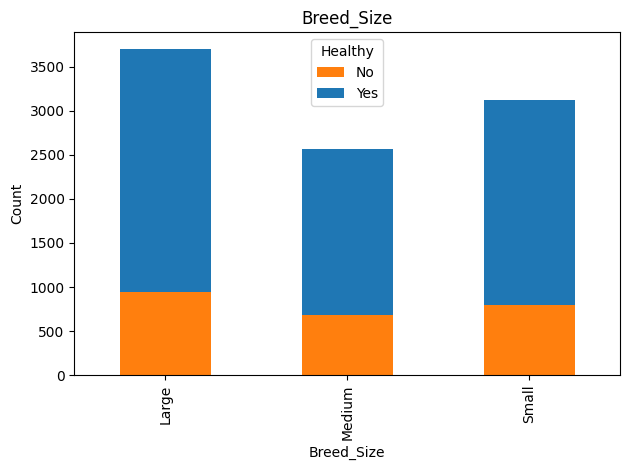

Graficando (categórica): Sex


<Figure size 800x400 with 0 Axes>

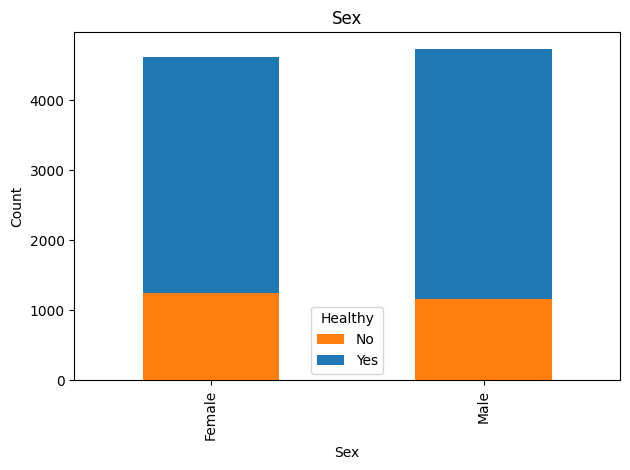

Graficando (categórica): SpayNeuter_Status


<Figure size 800x400 with 0 Axes>

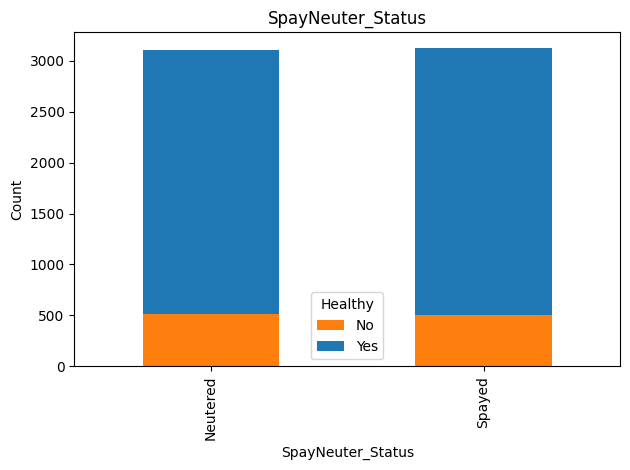

Graficando (categórica): Daily_Activity_Level


<Figure size 800x400 with 0 Axes>

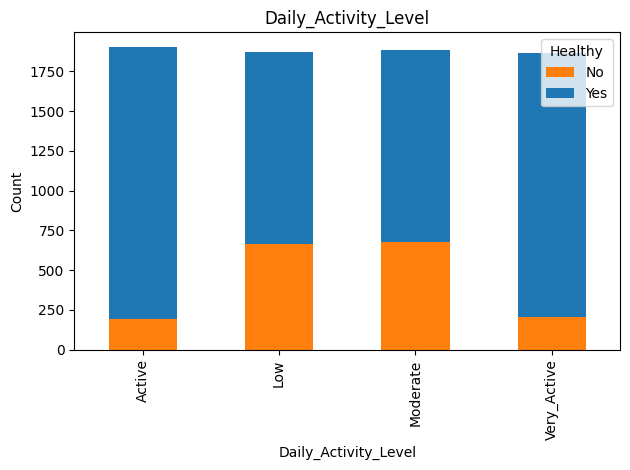

Graficando (categórica): Diet


<Figure size 800x400 with 0 Axes>

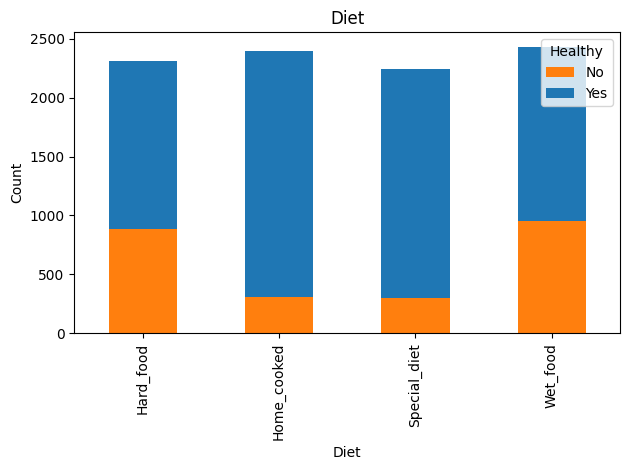

Graficando (categórica): Food_Brand


<Figure size 800x400 with 0 Axes>

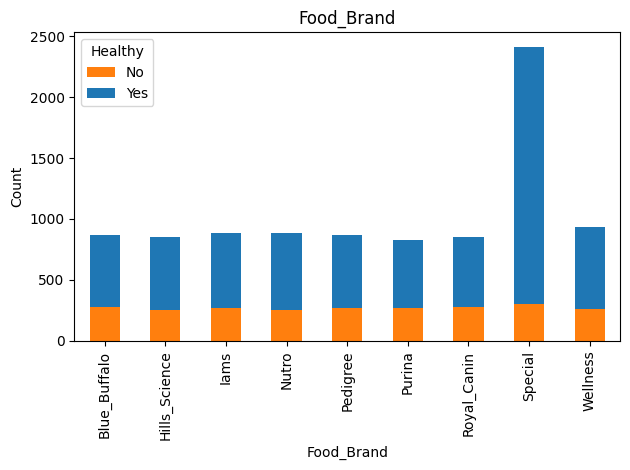

Graficando (categórica): Other_Pets_in_Household


<Figure size 800x400 with 0 Axes>

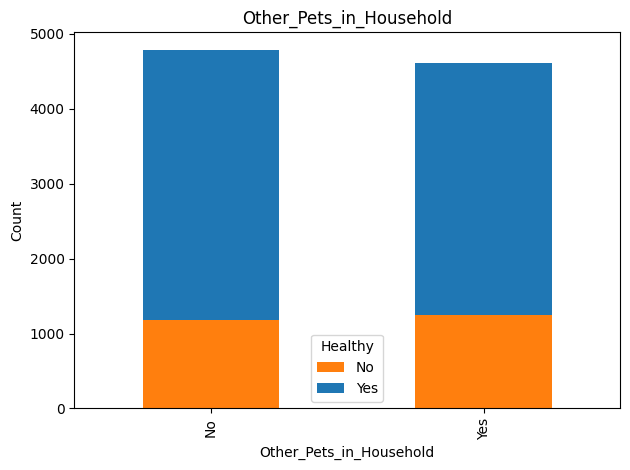

Graficando (categórica): Medications


<Figure size 800x400 with 0 Axes>

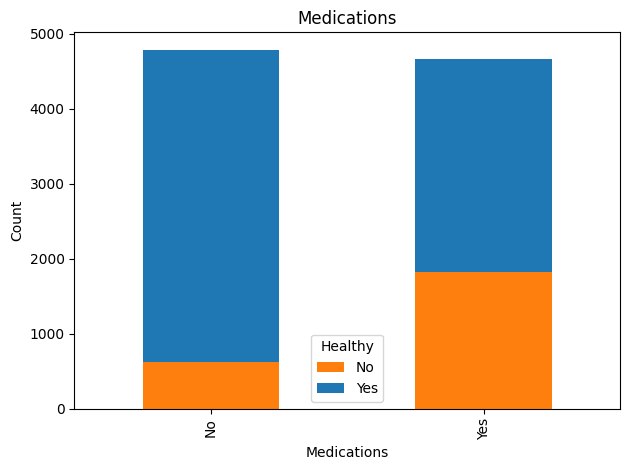

Graficando (categórica): Seizures


<Figure size 800x400 with 0 Axes>

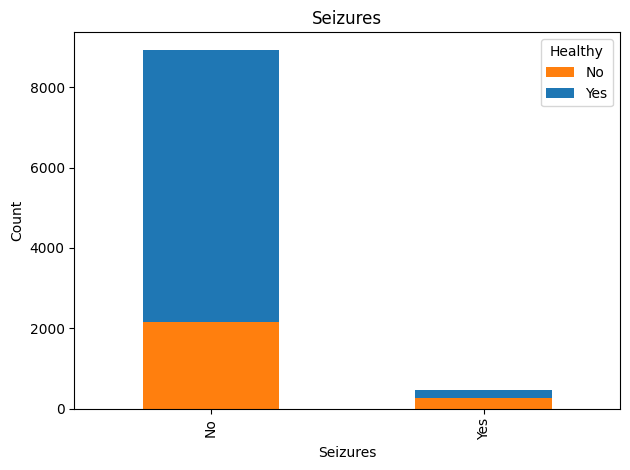

Graficando (categórica): Owner_Activity_Level


<Figure size 800x400 with 0 Axes>

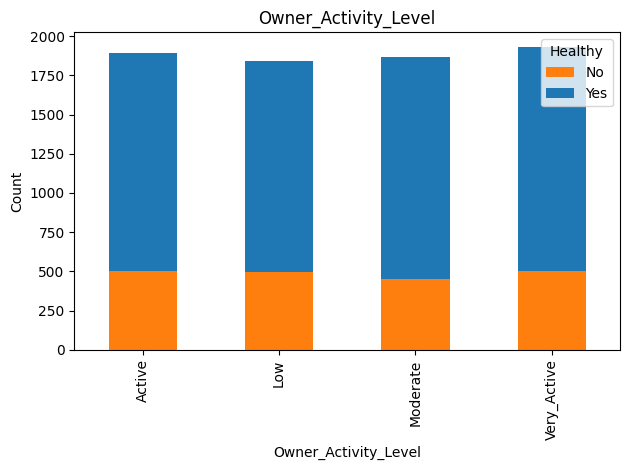

Graficando (categórica): Synthetic


<Figure size 800x400 with 0 Axes>

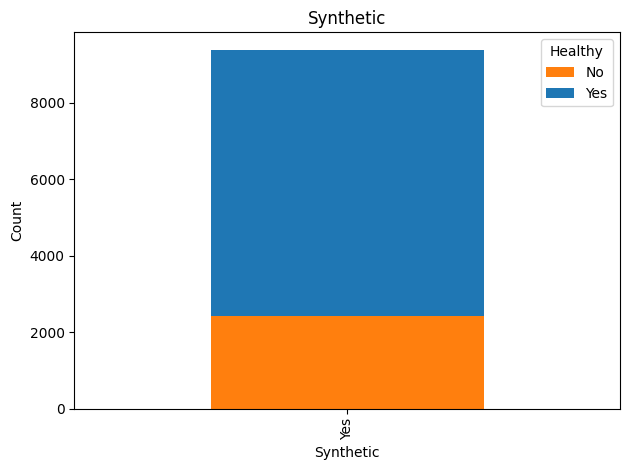

Graficando (numérica): Age


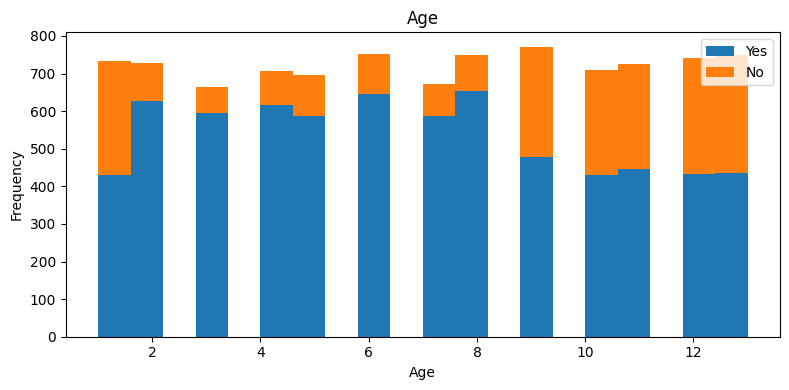

Graficando (numérica): Weight_lbs


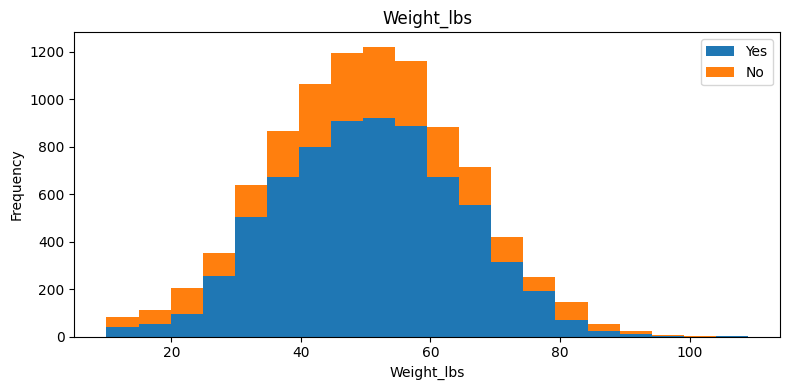

Graficando (numérica): Daily_Walk_Distance_miles


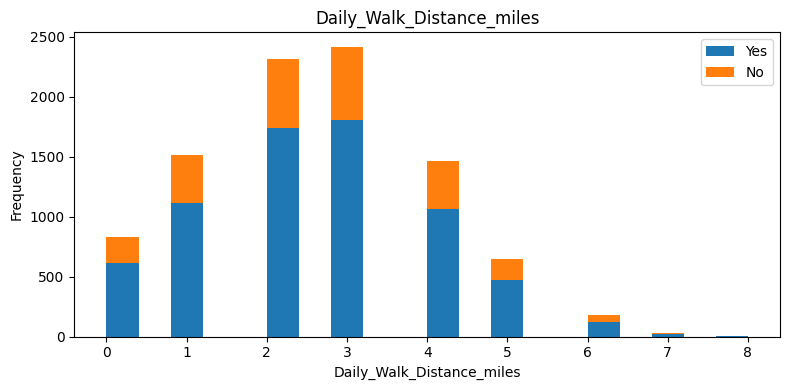

Graficando (numérica): Hours_of_Sleep


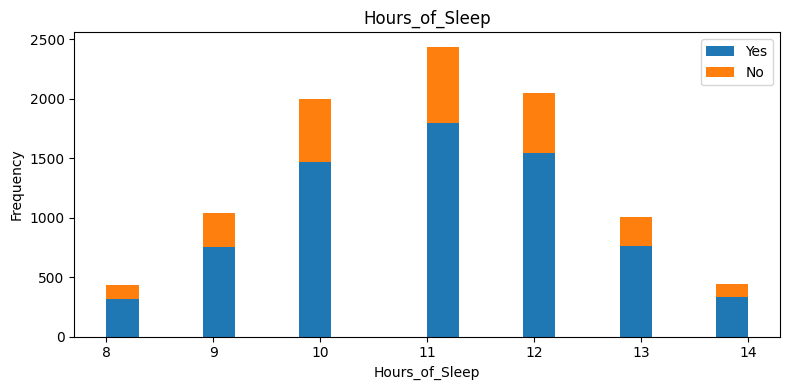

Graficando (numérica): Play_Time_hrs


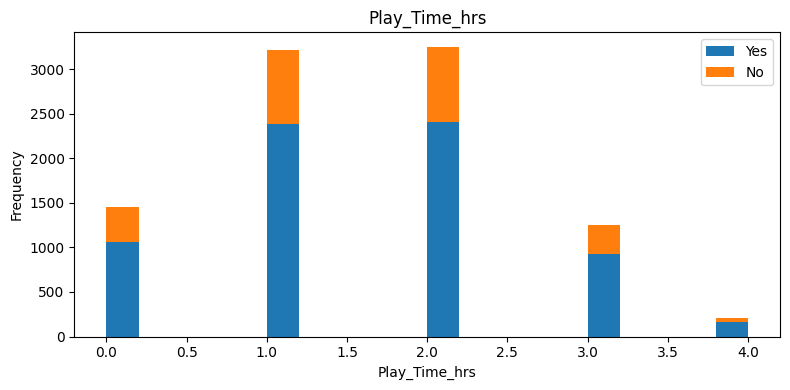

Graficando (numérica): Annual_Vet_Visits


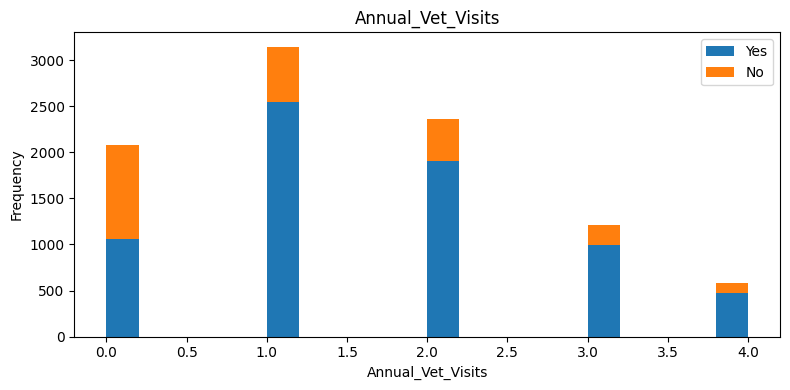

Graficando (numérica): Average_Temperature_F


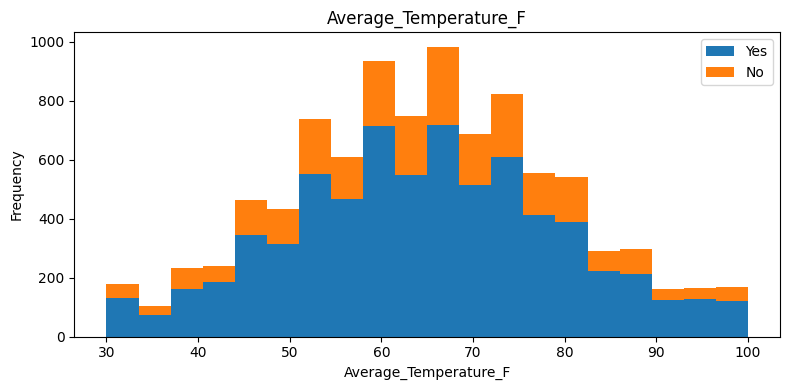

In [ ]:
# ---------------------------------------------------------
# 1. Cargar archivo
# ---------------------------------------------------------
#df = pd.read_csv("teste_weka.csv")

# Nombre de la clase (última columna)
class_col = df.columns[-1]
classes = df[class_col].unique()

# Asegurar orden estable de clases
#classes.sort()


# Colores solicitados
colors = {
    classes[0]: "#1f77b4",# azul
    classes[1]: "#ff7f0e" # naranja
}

# ---------------------------------------------------------
# 2. Separar columnas numéricas y categóricas
# ---------------------------------------------------------
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# Remover columna de clase de las listas
if class_col in numeric_cols:
    numeric_cols.remove(class_col)
if class_col in categorical_cols:
    categorical_cols.remove(class_col)

# ---------------------------------------------------------
# 3. Función para graficar atributos categóricos
# ---------------------------------------------------------
def plot_categorical(col):
    plt.figure(figsize=(8,4))
    
    # 1. Conteo por clase. Crear la tabla de conteos
    class_counts = df.groupby([col, class_col]).size().unstack(fill_value=0)

    # 2. Crear la lista de colores en el orden EXACTO de las columnas
    # Esto asegura que si la columna 1 es "no", use el color de "no", etc.
    ordered_colors = [colors[c] for c in class_counts.columns]

    
 # 3. Graficar pasando el argumento 'color'
    class_counts.plot(
        kind='bar', 
        stacked=True, 
        color=ordered_colors  # <--- AQUÍ es donde aplicas tu configuración
    )
    
    plt.title(f"{col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 4. Graficar numéricas (histogramas corregidos)
# ---------------------------------------------------------
def plot_numeric(col):
    plt.figure(figsize=(8,4))

    # 1. Recolectar todos los datos y colores en listas primero
    data_to_plot = []
    plot_colors = []
    labels = []

    for c in classes:
        # Extraer los datos de cada clase
        data_to_plot.append(df[df[class_col] == c][col])
        plot_colors.append(colors[c])
        labels.append(str(c))

    # 2. Llamar a plt.hist UNA sola vez con todas las listas
    plt.hist(
        data_to_plot,
        color=plot_colors,
        label=labels,
        bins=20,
        alpha=1.0,      # <-- IMPORTANTE: Opacidad total para respetar el color HEX
        stacked=True    # <-- Recomendado: Apila las barras igual que en tus variables categóricas
    )

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 5. Generar gráficos para todas las columnas
# ---------------------------------------------------------
for col in categorical_cols:
    print(f"Graficando (categórica): {col}")
    plot_categorical(col)

for col in numeric_cols:
    print(f"Graficando (numérica): {col}")
    plot_numeric(col)


**Prediccion**

Vamos a usar la prediccion para evaluar los siguientes casos para los modelos de RF y KNN:

- Con balanceo de clase 
- Sin balanceo de clase

Error de la clase minoritaria: 65.17135692393424 %


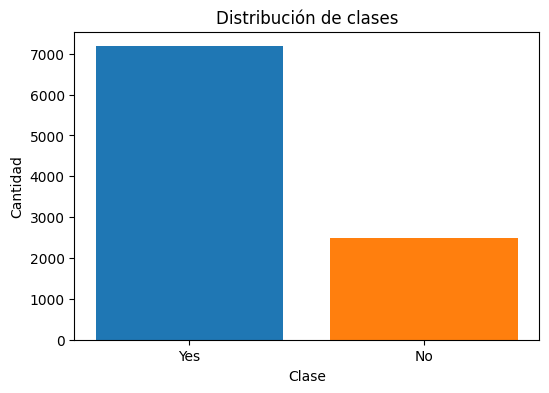

In [ ]:
# Analizamos el error de la clase minoritaria

Yes_class = df['Healthy'].value_counts().iloc[0]
No_class = df['Healthy'].value_counts().iloc[1]

error_class = 1 - (No_class/Yes_class)
print('Error de la clase minoritaria:', error_class*100, "%")

# Colores solicitados
colores = ['#1f77b4', '#ff7f0e']

# Gráfico de la distribucion de clases
plt.figure(figsize=(6,4))
plt.bar(conteo.index, conteo.values, color=colores)

plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Distribución de clases')
plt.show()

In [2]:
import pandas as pd
input_file = r'D:\Archivos\Profesion\CAN_BUS\PTI-Bolsa\NODos\Sniffer\Python_block\Dados_Belem\Test_conc_csv\All_Data-data-2025-11-28 10_31_42.csv' 

# --- 1. Cargar archivo ---
df = pd.read_csv(input_file)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Columns: 190 entries, _time to warning_codes value
dtypes: object(190)
memory usage: 185.7+ KB


,_time,AccelerationX value,AccelerationY value,AccelerationZ value,Altitude value,AltitudeAccuracy value,AngularRateX value,AngularRateY value,AngularRateZ value,Avg_Cell_Resistance value,...,VCU1_VehicleSpeed value,VVVF_status_AMode value,enable_HW_enable_echo value,error_codes value,error_values value,in_current_charger_4C4D value,in_current_solar_charger_4E4F value,out_current_load_4A4B value,safety_disconnection_HW_echo value,warning_codes value
0,2025-11-01 01:00:00,-0.282 °,-6.98 °,6.95 °,-26.8 °,1 °,-0.666 °,-0.225 °,-0.226 °,0 °,...,NaN,0 °,0.963 °,0.296 °,0 °,0 °,0 °,0 °,0.963 °,0 °
1,2025-11-01 02:00:00,-0.336 °,-6.98 °,6.94 °,-27.0 °,1.23 °,-0.678 °,-0.211 °,-0.237 °,0 °,...,0 °,0 °,0.744 °,0.282 °,-0.359 °,0 °,0 °,0 °,0.744 °,0 °
2,2025-11-01 03:00:00,-0.351 °,-6.96 °,6.94 °,-24.2 °,1.28 °,-0.682 °,-0.154 °,-0.289 °,0 °,...,NaN,0 °,0.781 °,0.688 °,-4.62 °,0 °,0 °,0 °,0.781 °,0 °
3,2025-11-01 04:00:00,-0.363 °,-7.07 °,6.83 °,-30.2 °,2.95 °,-0.705 °,-0.289 °,-0.197 °,0 °,...,NaN,0 °,0.138 °,0 °,0 °,0 °,0 °,0 °,0.138 °,0 °
4,2025-11-01 05:00:00,-0.418 °,-7.19 °,6.73 °,-16.2 °,1.16 °,-0.652 °,-0.132 °,-0.334 °,0 °,...,NaN,0 °,0 °,0 °,0 °,0 °,0 °,0 °,0 °,0 °


In [4]:
df.columns.tolist()

['_time',
 'AccelerationX value',
 'AccelerationY value',
 'AccelerationZ value',
 'Altitude value',
 'AltitudeAccuracy value',
 'AngularRateX value',
 'AngularRateY value',
 'AngularRateZ value',
 'Avg_Cell_Resistance value',
 'Avg_Opencell_Voltage value',
 'BGS1_ChgStartToReChg value',
 'BGS1_MaxAllowChargeCurr value',
 'BGS1_MaxAllowChargeEndVolt value',
 'BGS1_Mode value',
 'BGS1_Retain value',
 'BMS_AverageTemperature value',
 'BMS_AverageVoltage value',
 'BMS_BatteryPower value',
 'BMS_CellHVMax value',
 'BMS_CellHVMaxNum value',
 'BMS_CellHeatingTempStartNum value',
 'BMS_CellHeatingTempT1 value',
 'BMS_CellHeatingTempT2 value',
 'BMS_CellHeatingTempT3 value',
 'BMS_CellHeatingTempT4 value',
 'BMS_CellHeatingTempT5 value',
 'BMS_CellHeatingTempT6 value',
 'BMS_CellLVMax value',
 'BMS_CellLVMaxNum value',
 'BMS_CellNumber value',
 'BMS_CellTempNumber value',
 'BMS_CellTempStartNum value',
 'BMS_CellTemperatureT1 value',
 'BMS_CellTemperatureT2 value',
 'BMS_CellTemperatureT3 valu